### Rather than every critical and emerging technology, I want to focus on only three and their sub-fields at this time. I will apply non-negative matrix factorization rather than LDA. I will also solely use arXiv for this as it is an open access archive.

In [2]:
import arxiv
import csv
from datetime import datetime

topics = {
    "Advanced Computing": [
        "Advanced supercomputing", "Edge computing", "Advanced cloud services", 
        "High-performance data storage", "Advanced computing architectures", 
        "Advanced modeling and simulation", "Data processing and analysis techniques", 
        "Spatial computing", "Data Privacy", "Data Security"
    ],
    "Cybersecurity Technologies": [
        "Distributed ledger technologies", "Digital assets", "Communications and network security", 
        "Privacy-enhancing technologies", "Distributed confidential computing"
    ],
    "Semiconductors and Microelectronics": [
        "Design automation tools", "Advanced manufacturing processes", "Microelectronics for AI", 
        "MEMS/NEMS", "Novel architectures for non-Von Neumann computing"
    ]
}

def collect_papers_from_arxiv(topic_dict, max_results_per_query=50, years_back=5):
    all_papers = []
    current_year = datetime.now().year
    min_year = current_year - years_back

    for main_topic, sub_fields in topic_dict.items():
        for sub_field in sub_fields:
            print(f"Searching for papers on: {sub_field} under {main_topic}")
            try:
                # Query arXiv for papers related to the sub-field
                search = arxiv.Search(
                    query=sub_field,
                    max_results=max_results_per_query,
                    sort_by=arxiv.SortCriterion.SubmittedDate
                )
                
                for result in search.results():
                    pub_year = result.published.year
                    if pub_year >= min_year:
                        paper_info = {
                            "topic": main_topic,
                            "sub_field": sub_field,
                            "title": result.title,
                            "abstract": result.summary,
                            "author": ", ".join([author.name for author in result.authors]),
                            "year": pub_year,
                            "url": result.entry_id,
                            "categories": ", ".join(result.categories)
                        }
                        all_papers.append(paper_info)
            except Exception as e:
                print(f"Error occurred while searching for {sub_field}: {e}")

    return all_papers

def save_to_csv(papers, filename='arxiv_papers.csv'):
    if papers:
        keys = papers[0].keys()
        with open(filename, 'w', newline='', encoding='utf-8') as output_file:
            dict_writer = csv.DictWriter(output_file, fieldnames=keys)
            dict_writer.writeheader()
            dict_writer.writerows(papers)

papers = collect_papers_from_arxiv(topics, max_results_per_query=50, years_back=5)
save_to_csv(papers, 'arxiv_tech_papers_last_5_years.csv')

Searching for papers on: Advanced supercomputing under Advanced Computing


/var/folders/m0/g37kw4bx56g21n4sq6kkmspr0000gn/T/ipykernel_80507/2251583452.py:40: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


Searching for papers on: Edge computing under Advanced Computing
Searching for papers on: Advanced cloud services under Advanced Computing
Searching for papers on: High-performance data storage under Advanced Computing
Searching for papers on: Advanced computing architectures under Advanced Computing
Searching for papers on: Advanced modeling and simulation under Advanced Computing
Searching for papers on: Data processing and analysis techniques under Advanced Computing
Searching for papers on: Spatial computing under Advanced Computing
Searching for papers on: Data Privacy under Advanced Computing
Searching for papers on: Data Security under Advanced Computing
Searching for papers on: Distributed ledger technologies under Cybersecurity Technologies
Searching for papers on: Digital assets under Cybersecurity Technologies
Searching for papers on: Communications and network security under Cybersecurity Technologies
Searching for papers on: Privacy-enhancing technologies under Cybersecuri

In [18]:
import nltk
from nltk.corpus import stopwords
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")

# Adding a list of custom stop words. Can be adjusted after viewing keywords
custom_stop_words = [
    "research", "study", "result", "method", "paper", "approach", "data", "analysis", "model", "find", "use", "example", "user", "show",
    "solution", "number", "task", "human", "learning", "base", "source", "time", "point", "include", "propose", "provide", "control",
    "point", "challenge", "work", "problem", "truth", "object", "bev", "cost", "function"
]

default_stop_words = set(stopwords.words('english'))

combined_stop_words = list(default_stop_words.union(set(custom_stop_words)))  # Convert to a list

def preprocess_text(text, stop_words):
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization and lemmatization using spaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]
    
    return " ".join(tokens)

# Function to preprocess abstracts
def preprocess_abstracts(papers, stop_words):
    for paper in papers:
        paper['cleaned_abstract'] = preprocess_text(paper['abstract'], stop_words)
    return papers

def preprocess_and_vectorize(papers, stop_words):
    papers = preprocess_abstracts(papers, stop_words)
    
    vectorizer = TfidfVectorizer(max_df=0.99, min_df=10, stop_words=stop_words, ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform([paper['cleaned_abstract'] for paper in papers])
    
    return tfidf_matrix, vectorizer

tfidf_matrix, vectorizer = preprocess_and_vectorize(papers, combined_stop_words)

# Function to fit the NMF model and extract topics
def build_nmf_model(tfidf_matrix, vectorizer, num_topics=5):
    nmf_model = NMF(n_components=num_topics, random_state=42)
    
    nmf_model.fit(tfidf_matrix)
    
    words = vectorizer.get_feature_names_out()
    
    # Display the top words for each topic
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([words[i] for i in topic.argsort()[:-11:-1]]))  # Starting with 10 words per topic
    
    return nmf_model

num_topics = 5  # Starting with 5 because we are only focusing on 3 CET's
nmf_model = build_nmf_model(tfidf_matrix, vectorizer, num_topics=num_topics)

# Function to assign topics to each document
def assign_topics_to_documents(nmf_model, tfidf_matrix, num_topics=4):
    topic_distribution = nmf_model.transform(tfidf_matrix)
    
    document_topics = np.argmax(topic_distribution, axis=1)
    
    return document_topics

document_topics = assign_topics_to_documents(nmf_model, tfidf_matrix, num_topics=num_topics)

for i, paper in enumerate(papers):
    paper['assigned_topic'] = document_topics[i] + 1  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeffreyimbrogno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic #1:
llm network system design performance distribution dataset image robot language
Topic #2:
quantum circuit computing qubit quantum computing gate qwc quantum circuit state stabilizer
Topic #3:
perception lidar driving visual ground capability urban semantic perception technology nuscene
Topic #4:
instruction multimodal multimodal instruction evolution prosim traffic prompt mmevol cognitive mllm
Topic #5:
ml rl ml community quantum compute quantum reinforcement community compute field ml technique


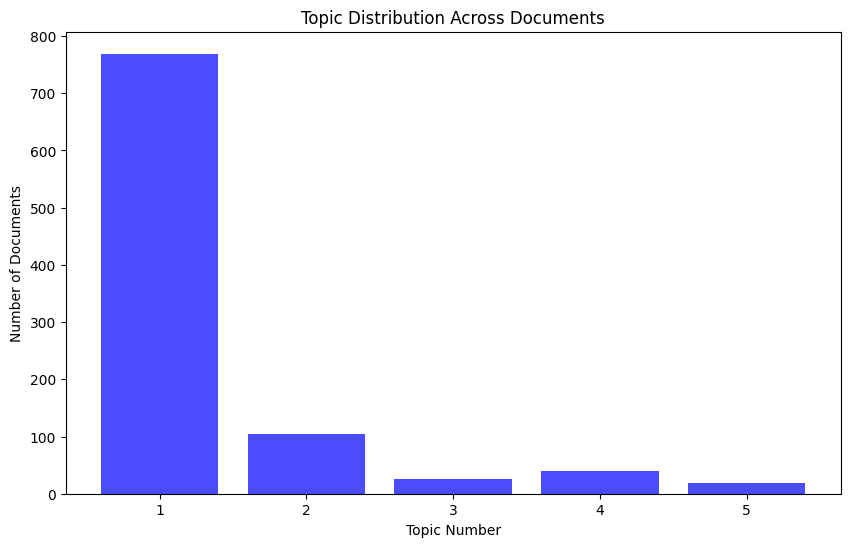

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_topic_distribution(document_topics, num_topics=4):
    topic_counts = np.bincount(document_topics, minlength=num_topics)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, num_topics + 1), topic_counts, color='blue', alpha=0.7)
    plt.xlabel('Topic Number')
    plt.ylabel('Number of Documents')
    plt.title('Topic Distribution Across Documents')
    plt.xticks(range(1, num_topics + 1))
    plt.show()

plot_topic_distribution(document_topics, num_topics=num_topics)

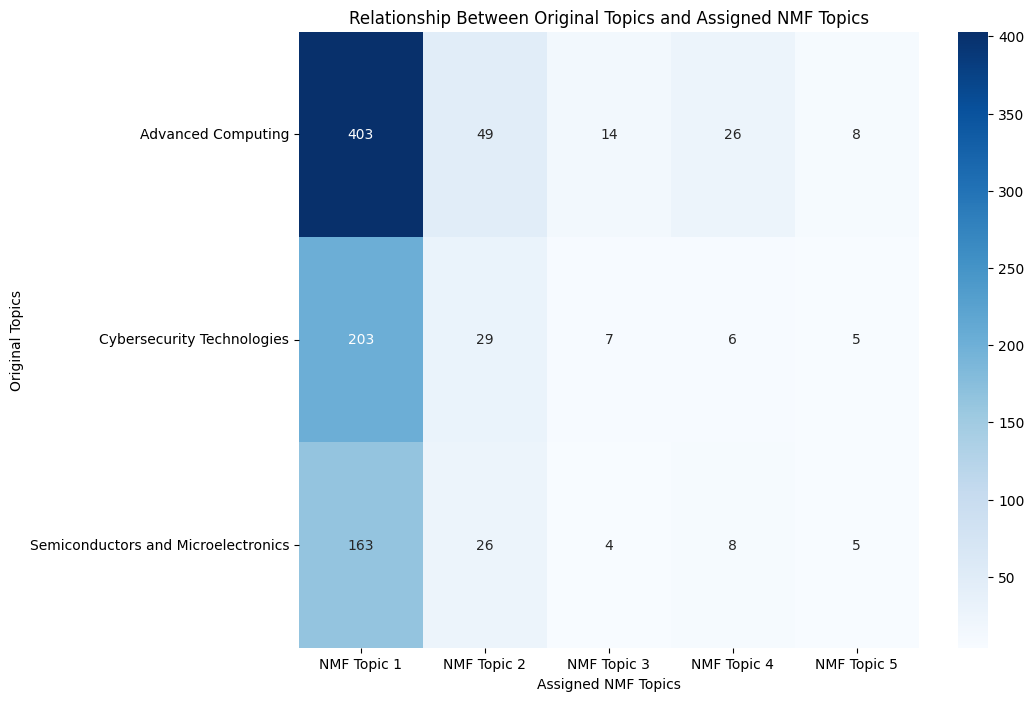

In [20]:
import seaborn as sns
import pandas as pd

def create_topic_assignment_matrix(papers, num_topics):
    topic_names = list(set(paper['topic'] for paper in papers))
    df = pd.DataFrame(0, index=topic_names, columns=[f"NMF Topic {i+1}" for i in range(num_topics)])
    
    for paper in papers:
        original_topic = paper['topic']
        assigned_topic = paper['assigned_topic']  # This is the topic assigned by NMF
        df.at[original_topic, f"NMF Topic {assigned_topic}"] += 1
    
    return df

def plot_topic_assignment_heatmap(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='Blues', fmt='d')
    plt.title("Relationship Between Original Topics and Assigned NMF Topics")
    plt.ylabel("Original Topics")
    plt.xlabel("Assigned NMF Topics")
    plt.show()

topic_assignment_matrix = create_topic_assignment_matrix(papers, num_topics)

plot_topic_assignment_heatmap(topic_assignment_matrix)

### In retrospect, advanced computing might not have been the best pick with the other two topics due to how broad the field is.

In [23]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

tokenized_texts = [paper['cleaned_abstract'].split() for paper in papers]

# Create a dictionary and corpus for gensim
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

top_words_per_topic = []
words = vectorizer.get_feature_names_out()
for topic in nmf_model.components_:
    top_words_per_topic.append([words[i] for i in topic.argsort()[:-11:-1]])

coherence_model = CoherenceModel(
    topics=top_words_per_topic,
    texts=tokenized_texts,
    dictionary=dictionary,
    coherence='c_v'  
)

# Aiming for a coherence score at least above 0.5
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.5656282044461992
